# Project Notebook

This project notebook replicates the work presented in the final report (ADD LINK).

#### Imports

In [66]:
# Basics
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries
from scipy.stats import norm, shapiro, kstest, chi2_contingency

# Kaplan-Meier Estimator
from lifelines import KaplanMeierFitter

# Custom utils functions
import sys; sys.path.append("./libraries/")
from utils import *

#### Settings

In [2]:
# Relative Paths
RAW_DATA = "../data/raw/"
PROC_DATA = "../data/processed/"

# Flags
process = False

# Data

## Load and match datasets
We have two different dataset sources with different identifiers. To match players from Transfermarkt with their attributes from soFIFA, we use a custom function that looks at their names, date of birth and nationality to ensure they are the same player.

In [3]:
# If process, load raw data and apply matching between datasets
# NOTE: It may take several minutes
if process:
    # Raw player's datasets
    transfermarkt = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
    fifa22 = pd.read_csv(RAW_DATA + "FIFA22_player_ratings.csv") # FIFA player attributes from 2022
    fifas21 = pd.read_csv(RAW_DATA + "FIFA21_player_ratings.csv") # FIFA player attributes from 2022
    # This appends players from 2021 not present in 2022
    extended = set(fifas21.sofifa_id).difference(set(fifa22.sofifa_id))
    FIFA = pd.concat([fifa22, fifas21[fifas21.sofifa_id.isin(extended)]]).reset_index()

    # Remove uninformative columns
    transfermarkt.drop(["player_code", "agent_name", "image_url", "url"], axis=1, inplace=True)
    FIFA.drop(["player_url", "club_team_id", "club_position", "club_jersey_number", "club_loaned_from", "club_joined", 
                "nationality_id", "nation_team_id", "nation_jersey_number", "real_face", "player_tags", "player_face_url", 
                "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url"], axis=1, inplace=True)
    
    # Find matches using custom function
    longname_matches = match_players(transfermarkt, FIFA)
    # Append the extracted FIFA long names
    transfermarkt["FIFA_long_name"] = longname_matches

    ## Merge players with FIFA attributes
    # Create a unique identifier with long name and year of birth
    transfermarkt["fifa_id"] = transfermarkt["FIFA_long_name"] + "-" + pd.to_datetime(transfermarkt["date_of_birth"]).dt.year.astype(str)
    FIFA["fifa_id"] = FIFA.long_name + "-" + pd.to_datetime(FIFA["dob"]).dt.year.astype(str)
    # Join
    players = transfermarkt.merge(FIFA, on="fifa_id", how="inner")
    # Drop temp id cols
    players.drop(["name", "fifa_id", "sofifa_id"], axis=1, inplace=True)
    # Save dataset
    players.to_csv(PROC_DATA + "players_wFIFAattributes.csv", index=False)

# Else load processed data
else:
    players = pd.read_csv(PROC_DATA + "players_wFIFAattributes.csv")

# Get valuation data
valuations = pd.read_csv('https://query.data.world/s/y4qg2twfvou4w2ghz6o3evju32g7yn?dws=00000') 
# ... (we can get some more datasets if needed)

# Glance at data
print(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Columns: 112 entries, player_id to gk
dtypes: float64(15), int64(44), object(53)
memory usage: 9.5+ MB
None


,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,3875,Jermain,Defoe,Jermain Colin Defoe,2021,England,London,England,1982-10-07,Centre-Forward,...,43+2,43+2,43+2,43+2,40+2,38+2,38+2,38+2,40+2,18+2
1,4742,Christophe,Lepoint,Christophe Lepoint,2022,Belgium,Brussel,Belgium,1984-10-24,Central Midfield,...,68-1,68-1,68-1,62+2,62+2,67,67,67,62+2,16+2
2,6838,Henok,Goitom,Henok Goitom,2015,Sweden,Solna,Eritrea,1984-09-22,Centre-Forward,...,55+2,55+2,55+2,50+2,48+2,50+2,50+2,50+2,48+2,17+2
3,10003,Wes,Morgan,Wes Morgan,2020,England,Nottingham,Jamaica,1984-01-21,Centre-Back,...,64+2,64+2,64+2,54+2,57+2,73,73,73,57+2,16+2
4,10471,NaN,Luiz Gustavo,Luiz Gustavo Dias,2021,Brazil,Pindamonhangaba,Brazil,1987-07-23,Defensive Midfield,...,75+2,75+2,75+2,71+3,71+3,75+2,75+2,75+2,71+3,17+3


# EDA
TODO

# Survival Analysis
The first step is to recognize retired players. We apply the assumption that a player is retired if he hasn't played for over a year, has no current club, no market value and no contract.

In [4]:
# Detect retired:
## Conditions:
### Last season < 2021
### No current club (NAN)
### No Market value in EUR (NAN)
### No Contract Expiration date (NAN)

# Use custom function generate boolean flag for "Retired" players
players = detect_retired(players)

# A glance to the retire players
players[players.retired].head()

,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,retired
13,26105,Valter,Birsa,Valter Birsa,2019,Jugoslawien (SFR),Sempeter pri Gorici,Slovenia,1986-08-07,Attacking Midfield,...,64+2,64+2,63+2,60+2,59+2,59+2,59+2,60+2,11+2,True
32,42086,Timo,Perthel,Timo Perthel,2013,Germany,Kaiserslautern,Germany,1989-02-11,Left-Back,...,64+2,64+2,65+1,64+2,64+2,64+2,64+2,64+2,15+2,True
57,56820,Jérémy,Sorbon,Jérémy Sorbon,2018,France,Caen,France,1983-08-05,Centre-Back,...,64+2,64+2,59+2,60+2,69,69,69,60+2,17+2,True
73,62240,Maynor,Figueroa,Maynor Alexis Figueroa Róchez,2014,Honduras,Jutiapa,Honduras,1983-05-02,Left-Back,...,66+2,66+2,63+2,63+2,68,68,68,63+2,17+2,True
119,101922,Fabio,Pisacane,Fabio Pisacane,2020,Italy,Napoli,Italy,1986-01-28,Centre-Back,...,65+2,65+2,66+2,67+2,70,70,70,67+2,19+2,True


## Retire Table
Similar to the life tables in traditional Survival Analysis, the "retire table" will compute the probability of retiring ('h') at a given age (based on their frequency), and a "Survival" ('S') probability at a given age, computed as the probability of NOT being retired at that age.

In [36]:
# We load the transfermarkt dataset, containing ~28k players
_ = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
# Some players are missing the date of birth, so we exclude those (only 42)
_ = _[~_.date_of_birth.isna()]
# Extract the age, and the "retired" flag
_["age"] = _["date_of_birth"].apply(lambda x: calculate_age(x)).astype(int)
_ = detect_retired(_)
                                                 
# Get the count and amount of retired players by age 
retire_table = _.groupby("age").agg({"age": "count", "retired": "sum"}).rename(columns={"age": "n"})

# Compute h_hat
retire_table["h"] = retire_table.retired / retire_table.n
retire_table = retire_table.reset_index(drop=False)

# Start with prob. 1
S = [1]

# Compute S
for ix, row in retire_table.iterrows():
    # Row zero is prob. 1
    if ix == 0:
        pass
    else:
        # The Survival probability of this year, is the prob. of having survived last year minus the hazard rate times the prob.
        S.append(S[ix-1] - (row.h * S[ix-1]))
    

retire_table["S"] = S
retire_table

,age,n,retired,h,S
0,14,7,0,0.000000,1.000000
1,15,79,0,0.000000,1.000000
2,16,274,2,0.007299,0.992701
3,17,628,5,0.007962,0.984797
4,18,1034,15,0.014507,0.970511
5,19,1230,33,0.026829,0.944473
6,20,1355,39,0.028782,0.917289
7,21,1492,67,0.044906,0.876097
8,22,1620,106,0.065432,0.818772
9,23,1669,135,0.080887,0.752544


We can also plot the histogram of all players' age in the Transfermarkt dataset, to get a sense of the age distribution across players.

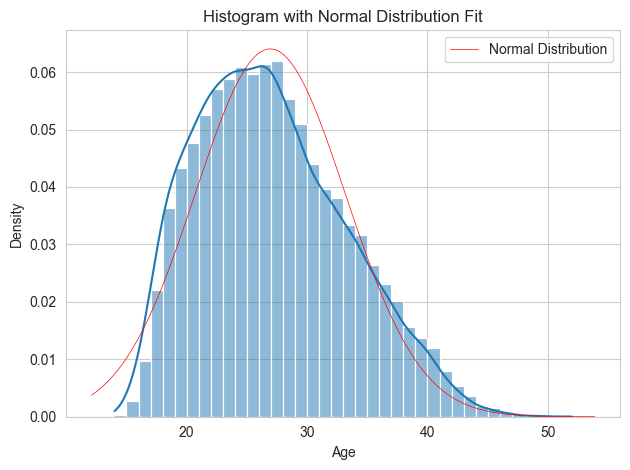

In [63]:
# Set the style
sns.set_style("whitegrid")

# Plot the histogram of ages
sns.histplot(data=_, x="age", kde=True, stat="density", bins=np.arange(_.age.min(), _.age.max() + 1))

# Fit a normal distribution to the data
mu, std = np.mean(_.age), np.std(_.age)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=0.5, label='Normal Distribution')

# Add labels and title
plt.title('Histogram with Normal Distribution Fit')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

The data appears roughly normally distributed, with a right tail. To test for a normal distribution fit, we use Shapiro-Wik test with an alpha level of 0.05. The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution. Since the Shapiro-Wilk test is not robust with large samples (+5000), we additionally test with the KS

In [73]:
# Select the alpha value
alpha = 0.05

# Perform the Shapiro-Wilk test
shapiro_stat, shapiro_p_value = shapiro(_.age)
ks_stat, ks_p_value = kstest(rvs=_.age, cdf='norm', alternative='two-sided')

if (shapiro_p_value > alpha) and (ks_p_value > alpha ):
    print(f"Data appears to be normally distributed (p-values {shapiro_p_value:.4f} and {ks_p_value:.4f})")
elif (shapiro_p_value < alpha) and (ks_p_value < alpha ):
    print(f"Data does not appear to be normally distributed (p-values {shapiro_p_value:.4f} and {ks_p_value:.4f})")
else:
    print(f"Inconclusive results (p-values {shapiro_p_value:.4f} and {ks_p_value:.4f})")

Data does not appear to be normally distributed (p-values 0.0000 and 0.0000)


c:\Users\ginof\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Finally, since our data is discrete (age), we perform a Chi-square test.

NOTE: WE PROBABLY SHOULD LEAVE ONLY THIS TEST

In [92]:
# Total observations
N = np.sum(retire_table.n)

# Parameters for the normal distribution (mean and standard deviation)
mean_age = np.mean(retire_table.age)
std_age = np.std(retire_table.age)

# Calculate the cumulative probabilities for each age
cumulative_probs = norm.cdf(retire_table.age + 0.5, loc=mean_age, scale=std_age) - norm.cdf(retire_table.age - 0.5, loc=mean_age, scale=std_age)

# Calculate expected frequencies
expected_frequencies = cumulative_probs * N

# Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency([retire_table.n, expected_frequencies])

print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

Chi-squared Statistic: 9545.740390915878
P-value: 0.0
Degrees of Freedom: 38


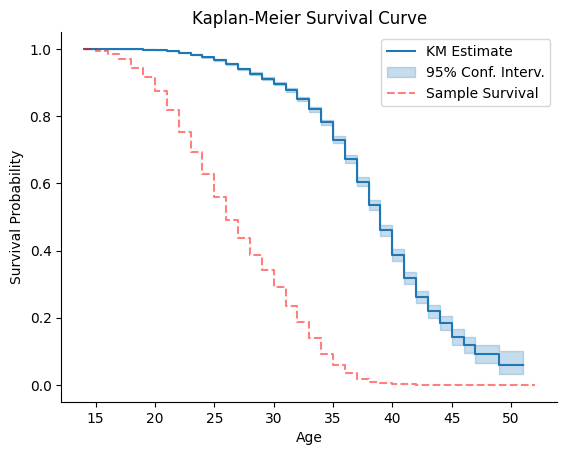

In [28]:
# Create a Kaplan-Meier estimator
kmf = KaplanMeierFitter(alpha=0.05)

# Fit the data to the estimator
kmf.fit(durations=_['age'], event_observed=_['retired'], timeline=range(_["age"].min(), _["age"].max()))

# Plot the Kaplan-Meier curve
ax = kmf.plot_survival_function()
# Look at the KM curves
sns.lineplot(data= retire_table, x="age", y= "S", drawstyle="steps", color="red", linestyle="--", alpha=0.5, ax=ax)

plt.title('Kaplan-Meier Survival Curve')
plt.legend(["KM Estimate", "95% Conf. Interv.", "Sample Survival"])
plt.xlabel('Age')
plt.ylabel('Survival Probability')
sns.despine()
plt.show()
